In [17]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
mypath = "./respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [19]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

In [20]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [21]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [22]:
p_diag = pd.read_csv("./respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [23]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [24]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  920  files


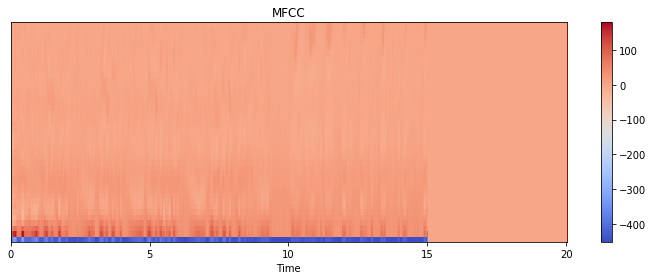

In [25]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [26]:
features = np.array(features) # convert to numpy array

In [27]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [28]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


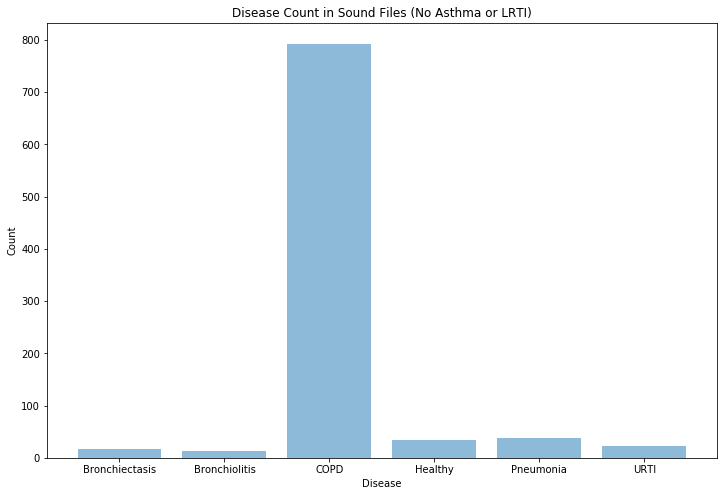

In [29]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [30]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

In [31]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

In [32]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

**Convolutional Neural Network (CNN) model architecture**

Our model will be a Convolutional Neural Network (CNN) using Keras and a Tensorflow backend.

We will use a sequential model, with a simple model architecture, consisting of four Conv2D convolution layers, with our final output layer being a dense layer.

The convolution layers are designed for feature detection. It works by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. This operation is known as a convolution.

The filter parameter specifies the number of nodes in each layer. Each layer will increase in size from 16, 32, 64 to 128, while the kernel_size parameter specifies the size of the kernel window which in this case is 2 resulting in a 2x2 filter matrix.

The first layer will receive the input shape of (40, 862, 1) where 40 is the number of MFCC's, 862 is the number of frames taking padding into account and the 1 signifying that the audio is mono.

The activation function we will be using for our convolutional layers is ReLU. We will use a small Dropout value of 20% on our convolutional layers.

Each convolutional layer has an associated pooling layer of MaxPooling2D type with the final convolutional layer having a GlobalAveragePooling2D type. The pooling layer is to reduce the dimensionality of the model (by reducing the parameters and subsquent computation requirements) which serves to shorten the training time and reduce overfitting. The Max Pooling type takes the maximum size for each window and the Global Average Pooling type takes the average which is suitable for feeding into our dense output layer.

Our output layer will have 6 nodes (num_labels) which matches the number of possible classifications. The activation is for our output layer is softmax. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [33]:
num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [34]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [35]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

**Training**

Here we will train the model. If we have a trained model, we can load it instead from the next cell.

In [36]:
# train model
num_epochs = 250
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 733 samples, validate on 184 samples
Epoch 1/250
640/733 [=========================>....] - ETA: 1s - loss: 4.6752 - accuracy: 0.6016
Epoch 00001: val_accuracy improved from -inf to 0.86413, saving model to mymodel2_01.h5
733/733 [==============================] - 16s 22ms/sample - loss: 4.7966 - accuracy: 0.6317 - val_loss: 2.3647 - val_accuracy: 0.8641
Epoch 2/250
640/733 [=========================>....] - ETA: 1s - loss: 3.8520 - accuracy: 0.8156
Epoch 00002: val_accuracy did not improve from 0.86413
733/733 [==============================] - 15s 20ms/sample - loss: 4.1172 - accuracy: 0.8158 - val_loss: 1.9138 - val_accuracy: 0.8641
Epoch 3/250
640/733 [=========================>....] - ETA: 1s - loss: 2.8458 - accuracy: 0.8547
Epoch 00003: val_accuracy did not improve from 0.86413
733/733 [==============================] - 15s 20ms/sample - loss: 2.6978 - accuracy: 0.8431 - val_loss: 1.2549 - val_accuracy: 0.8533
Epoch 4/250
640/733 [=========================>....] - ETA: 

640/733 [=========================>....] - ETA: 1s - loss: 0.3834 - accuracy: 0.8641
Epoch 00029: val_accuracy did not improve from 0.86413
733/733 [==============================] - 17s 23ms/sample - loss: 0.3835 - accuracy: 0.8663 - val_loss: 0.5603 - val_accuracy: 0.8641
Epoch 30/250
640/733 [=========================>....] - ETA: 1s - loss: 0.3895 - accuracy: 0.8625
Epoch 00030: val_accuracy did not improve from 0.86413
733/733 [==============================] - 15s 21ms/sample - loss: 0.3809 - accuracy: 0.8663 - val_loss: 0.5525 - val_accuracy: 0.8641
Epoch 31/250
640/733 [=========================>....] - ETA: 1s - loss: 0.3772 - accuracy: 0.8734
Epoch 00031: val_accuracy did not improve from 0.86413
733/733 [==============================] - 15s 20ms/sample - loss: 0.3818 - accuracy: 0.8704 - val_loss: 0.5428 - val_accuracy: 0.8641
Epoch 32/250
640/733 [=========================>....] - ETA: 1s - loss: 0.4142 - accuracy: 0.8609
Epoch 00032: val_accuracy did not improve from 0.86

Epoch 58/250
640/733 [=========================>....] - ETA: 2s - loss: 0.2900 - accuracy: 0.8844
Epoch 00058: val_accuracy did not improve from 0.86957
733/733 [==============================] - 20s 27ms/sample - loss: 0.3010 - accuracy: 0.8854 - val_loss: 0.4354 - val_accuracy: 0.8696
Epoch 59/250
640/733 [=========================>....] - ETA: 2s - loss: 0.2818 - accuracy: 0.8906
Epoch 00059: val_accuracy did not improve from 0.86957
733/733 [==============================] - 19s 26ms/sample - loss: 0.2868 - accuracy: 0.8895 - val_loss: 0.4548 - val_accuracy: 0.8641
Epoch 60/250
640/733 [=========================>....] - ETA: 2s - loss: 0.2871 - accuracy: 0.8875
Epoch 00060: val_accuracy did not improve from 0.86957
733/733 [==============================] - 17s 23ms/sample - loss: 0.2843 - accuracy: 0.8909 - val_loss: 0.4393 - val_accuracy: 0.8696
Epoch 61/250
640/733 [=========================>....] - ETA: 1s - loss: 0.2645 - accuracy: 0.8984
Epoch 00061: val_accuracy did not impr

640/733 [=========================>....] - ETA: 1s - loss: 0.2059 - accuracy: 0.9172
Epoch 00086: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.2146 - accuracy: 0.9141 - val_loss: 0.4163 - val_accuracy: 0.8641
Epoch 87/250
640/733 [=========================>....] - ETA: 1s - loss: 0.2283 - accuracy: 0.9141
Epoch 00087: val_accuracy did not improve from 0.88043
733/733 [==============================] - 14s 19ms/sample - loss: 0.2330 - accuracy: 0.9113 - val_loss: 0.4530 - val_accuracy: 0.8696
Epoch 88/250
640/733 [=========================>....] - ETA: 1s - loss: 0.2023 - accuracy: 0.9203
Epoch 00088: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.2068 - accuracy: 0.9181 - val_loss: 0.4475 - val_accuracy: 0.8696
Epoch 89/250
640/733 [=========================>....] - ETA: 1s - loss: 0.2110 - accuracy: 0.9156
Epoch 00089: val_accuracy did not improve from 0.88

Epoch 115/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1631 - accuracy: 0.9359
Epoch 00115: val_accuracy did not improve from 0.88043
733/733 [==============================] - 14s 20ms/sample - loss: 0.1679 - accuracy: 0.9318 - val_loss: 0.4570 - val_accuracy: 0.8696
Epoch 116/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1751 - accuracy: 0.9297
Epoch 00116: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.1745 - accuracy: 0.9332 - val_loss: 0.4457 - val_accuracy: 0.8641
Epoch 117/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1654 - accuracy: 0.9344
Epoch 00117: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.1574 - accuracy: 0.9386 - val_loss: 0.4796 - val_accuracy: 0.8641
Epoch 118/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1920 - accuracy: 0.9187
Epoch 00118: val_accuracy did not 

Epoch 144/250
640/733 [=========================>....] - ETA: 2s - loss: 0.1635 - accuracy: 0.9203
Epoch 00144: val_accuracy did not improve from 0.88043
733/733 [==============================] - 19s 25ms/sample - loss: 0.1527 - accuracy: 0.9250 - val_loss: 0.5046 - val_accuracy: 0.8641
Epoch 145/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1378 - accuracy: 0.9469
Epoch 00145: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.1345 - accuracy: 0.9482 - val_loss: 0.5145 - val_accuracy: 0.8696
Epoch 146/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1302 - accuracy: 0.9500
Epoch 00146: val_accuracy did not improve from 0.88043
733/733 [==============================] - 14s 20ms/sample - loss: 0.1370 - accuracy: 0.9468 - val_loss: 0.5236 - val_accuracy: 0.8478
Epoch 147/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1484 - accuracy: 0.9328
Epoch 00147: val_accuracy did not 

Epoch 173/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1099 - accuracy: 0.9531
Epoch 00173: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 21ms/sample - loss: 0.1031 - accuracy: 0.9577 - val_loss: 0.5291 - val_accuracy: 0.8696
Epoch 174/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1151 - accuracy: 0.9500
Epoch 00174: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.1289 - accuracy: 0.9468 - val_loss: 0.5718 - val_accuracy: 0.8533
Epoch 175/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1401 - accuracy: 0.9531
Epoch 00175: val_accuracy did not improve from 0.88043
733/733 [==============================] - 14s 19ms/sample - loss: 0.1395 - accuracy: 0.9495 - val_loss: 0.5397 - val_accuracy: 0.8641
Epoch 176/250
640/733 [=========================>....] - ETA: 1s - loss: 0.1188 - accuracy: 0.9516
Epoch 00176: val_accuracy did not 

Epoch 202/250
640/733 [=========================>....] - ETA: 1s - loss: 0.0692 - accuracy: 0.9719
Epoch 00202: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.0708 - accuracy: 0.9741 - val_loss: 0.6809 - val_accuracy: 0.8587
Epoch 203/250
640/733 [=========================>....] - ETA: 1s - loss: 0.0748 - accuracy: 0.9750
Epoch 00203: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 21ms/sample - loss: 0.0733 - accuracy: 0.9754 - val_loss: 0.6014 - val_accuracy: 0.8750
Epoch 204/250
640/733 [=========================>....] - ETA: 1s - loss: 0.0769 - accuracy: 0.9703
Epoch 00204: val_accuracy did not improve from 0.88043
733/733 [==============================] - 15s 20ms/sample - loss: 0.0745 - accuracy: 0.9714 - val_loss: 0.6655 - val_accuracy: 0.8533
Epoch 205/250
640/733 [=========================>....] - ETA: 1s - loss: 0.0827 - accuracy: 0.9734
Epoch 00205: val_accuracy did not 

640/733 [=========================>....] - ETA: 1s - loss: 0.0821 - accuracy: 0.9625
Epoch 00230: val_accuracy did not improve from 0.88587
733/733 [==============================] - 14s 20ms/sample - loss: 0.0833 - accuracy: 0.9618 - val_loss: 0.6473 - val_accuracy: 0.8859
Epoch 231/250
640/733 [=========================>....] - ETA: 1s - loss: 0.0651 - accuracy: 0.9766
Epoch 00231: val_accuracy did not improve from 0.88587
733/733 [==============================] - 15s 20ms/sample - loss: 0.0643 - accuracy: 0.9768 - val_loss: 0.6563 - val_accuracy: 0.8641
Epoch 232/250
640/733 [=========================>....] - ETA: 1s - loss: 0.0801 - accuracy: 0.9734
Epoch 00232: val_accuracy did not improve from 0.88587
733/733 [==============================] - 16s 22ms/sample - loss: 0.0831 - accuracy: 0.9714 - val_loss: 0.6768 - val_accuracy: 0.8804
Epoch 233/250
640/733 [=========================>....] - ETA: 1s - loss: 0.0904 - accuracy: 0.9656
Epoch 00233: val_accuracy did not improve from 0

**Test the model**

Here we will review the accuracy of the model on both the training and test data sets.

In [37]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9399727
Testing Accuracy:  0.8804348


In [38]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=6 # number of classes

In [39]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [40]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

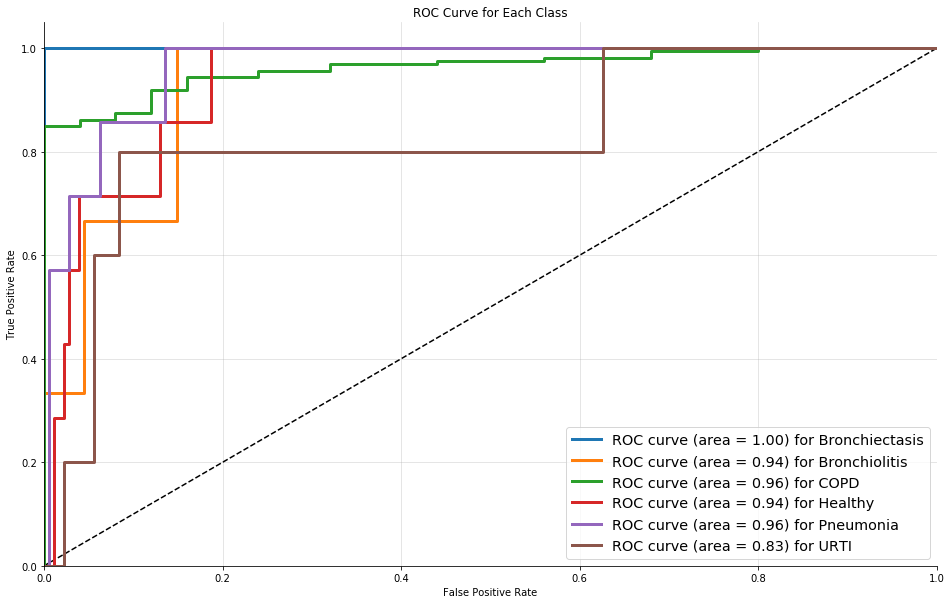

In [41]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [42]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       1.00      1.00      1.00         3
 Bronchiolitis       0.25      0.33      0.29         3
          COPD       0.93      0.97      0.95       159
       Healthy       0.00      0.00      0.00         7
     Pneumonia       0.67      0.29      0.40         7
          URTI       0.17      0.20      0.18         5

      accuracy                           0.88       184
     macro avg       0.50      0.47      0.47       184
  weighted avg       0.86      0.88      0.87       184



In [43]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  3   0   0   0   0   0]
 [  0   1   0   1   0   1]
 [  0   0 155   1   1   2]
 [  0   2   3   0   0   2]
 [  0   0   5   0   2   0]
 [  0   1   3   0   0   1]]
